In [67]:
import pickle
import dgl
import networkx as nx

dir = './degree/BNU1_fMRI/norm_flag_no/graphs'
file = open(dir,'rb')
graphs = pickle.load(file)
for i in graphs:
    for j in i:
        di = dgl.from_networkx(j)
        print(di)

Graph(num_nodes=17, num_edges=33,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=32, num_edges=89,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=37, num_edges=139,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=47, num_edges=203,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=52, num_edges=255,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=53, num_edges=310,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=54, num_edges=332,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=54, num_edges=370,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=54, num_edges=411,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=58, num_edges=451,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=58, num_edges=483,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=58, num_edges=503,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=59

In [ ]:
import dgl
from dgl.data import DGLDataset
import torch
import os

edges_fMRI = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
# edges_dMRI_fused = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_fused.csv')
# edges_dMRI_ses1 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses1.csv')
# edges_dMRI_ses2 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses2.csv')
properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')

edges_fMRI.head()

properties.head()

class BNU1Dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
        properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            weight = edges_of_id['weight'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            weight = torch.FloatTensor(weight)
            g.edata['weight'] = weight
            g = dgl.add_self_loop(g)
            print(list(g.nodes))
            a
            sg = dgl.sampling.sample_neighbors(g, g.nodes, 1)
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = BNU1Dataset()
graph, label = dataset[0]
print(graph, label)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
import dgl
from dgl.data import DGLDataset
import torch
import os

edges_fMRI = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
# edges_dMRI_fused = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_fused.csv')
# edges_dMRI_ses1 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses1.csv')
# edges_dMRI_ses2 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses2.csv')
properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')

edges_fMRI.head()

properties.head()

class BNU1Dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
        properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            weight = edges_of_id['weight'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            weight = torch.FloatTensor(weight)
            g.edata['weight'] = weight
            g = dgl.add_self_loop(g)
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = BNU1Dataset()
graph, label = dataset[0]
print(graph, label)

Using backend: pytorch


Graph(num_nodes=70, num_edges=94,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}) tensor(1)


In [18]:
import dgl.nn.pytorch as dglnn
from dgl.data.utils import split_dataset
import torch.nn as nn
import torch.nn.functional as F

class GCN_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(GCN_Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
#         self.conv3 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
#         h = F.relu(self.conv3(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

trainset, validset, testset = split_dataset(dataset, shuffle=True)
        
from dgl.dataloading import GraphDataLoader
import torch.optim as optim

Epoch 0, loss 0.7194
Epoch 1, loss 0.7164
Epoch 2, loss 0.7170
Epoch 3, loss 0.7170
Epoch 4, loss 0.7154
Epoch 5, loss 0.7145
Epoch 6, loss 0.7111
Epoch 7, loss 0.7126
Epoch 8, loss 0.7156
Epoch 9, loss 0.7122
Epoch 10, loss 0.7138
Epoch 11, loss 0.7101
Epoch 12, loss 0.7089
Epoch 13, loss 0.7102
Epoch 14, loss 0.7092
Epoch 15, loss 0.7096
Epoch 16, loss 0.7099
Epoch 17, loss 0.7064
Epoch 18, loss 0.7078
Epoch 19, loss 0.7092
Epoch 20, loss 0.7080
Epoch 21, loss 0.7071
Epoch 22, loss 0.7065
Epoch 23, loss 0.7052
Epoch 24, loss 0.7084
Epoch 25, loss 0.7057
Epoch 26, loss 0.7044
Epoch 27, loss 0.7054
Epoch 28, loss 0.7046
Epoch 29, loss 0.7051
Epoch 30, loss 0.7045
Epoch 31, loss 0.7043
Epoch 32, loss 0.7024
Epoch 33, loss 0.7039
Epoch 34, loss 0.7027
Epoch 35, loss 0.7016
Epoch 36, loss 0.7019
Epoch 37, loss 0.7014
Epoch 38, loss 0.7025
Epoch 39, loss 0.7018
Epoch 40, loss 0.7014
Epoch 41, loss 0.7005
Epoch 42, loss 0.7008
Epoch 43, loss 0.6997
Epoch 44, loss 0.6994
Epoch 45, loss 0.699

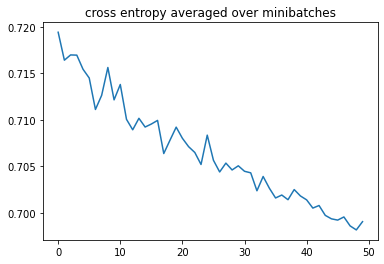

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]]) tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
Accuracy of predictions on the test set: 71.4286%


In [54]:
data_loader = GraphDataLoader(trainset, batch_size=16, shuffle=True)

model = GCN_Classifier(1, 16, 2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
# test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
pred_Y = torch.argmax(probs_Y, dim=1, keepdim=True)
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(test_Y, pred_Y)
print('Accuracy of predictions on the test set: {:.4f}%'.format(
    (test_Y == pred_Y.float()).sum().item() / len(test_Y) * 100))

Epoch 0, loss 0.7176
Epoch 1, loss 0.7185
Epoch 2, loss 0.7171
Epoch 3, loss 0.7117
Epoch 4, loss 0.7187
Epoch 5, loss 0.7221
Epoch 6, loss 0.7133
Epoch 7, loss 0.6962
Epoch 8, loss 0.7062
Epoch 9, loss 0.7047
Epoch 10, loss 0.6962
Epoch 11, loss 0.6925
Epoch 12, loss 0.6890
Epoch 13, loss 0.6929
Epoch 14, loss 0.6895
Epoch 15, loss 0.6968
Epoch 16, loss 0.6781
Epoch 17, loss 0.6925
Epoch 18, loss 0.6788
Epoch 19, loss 0.6909
Epoch 20, loss 0.6902
Epoch 21, loss 0.6810
Epoch 22, loss 0.6818
Epoch 23, loss 0.6761
Epoch 24, loss 0.6798
Epoch 25, loss 0.6802
Epoch 26, loss 0.6806
Epoch 27, loss 0.6821
Epoch 28, loss 0.6784
Epoch 29, loss 0.6759
Epoch 30, loss 0.6789
Epoch 31, loss 0.6788
Epoch 32, loss 0.6805
Epoch 33, loss 0.6829
Epoch 34, loss 0.6802
Epoch 35, loss 0.6810
Epoch 36, loss 0.6720
Epoch 37, loss 0.6749
Epoch 38, loss 0.6775
Epoch 39, loss 0.6775
Epoch 40, loss 0.6695
Epoch 41, loss 0.6771
Epoch 42, loss 0.6779
Epoch 43, loss 0.6767
Epoch 44, loss 0.6747
Epoch 45, loss 0.680

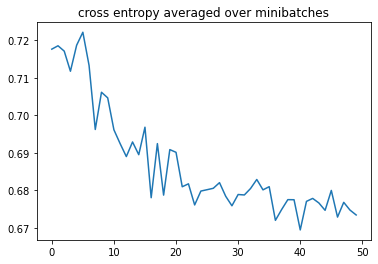

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]]) tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
Accuracy of predictions on the test set: 28.5714%


In [56]:
class GAT_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_heads, n_classes):
        super(GAT_Classifier, self).__init__()
        self.conv1 = dglnn.GATConv(in_dim, hidden_dim, num_heads, residual=True)
        self.conv2 = dglnn.GATConv(num_heads*hidden_dim, num_heads*hidden_dim, num_heads, residual=True)
        self.classify = nn.Linear(num_heads*num_heads*hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = torch.reshape(h, (h.shape[0], -1))
        h = F.relu(self.conv2(g, h))
        h = torch.reshape(h, (h.shape[0], -1))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


data_loader = GraphDataLoader(trainset, batch_size=16, shuffle=True)

model = GAT_Classifier(1, 16, 2, 2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
# test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
pred_Y = torch.argmax(probs_Y, dim=1, keepdim=True)
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(test_Y, pred_Y)
print('Accuracy of predictions on the test set: {:.4f}%'.format(
    (test_Y == pred_Y.float()).sum().item() / len(test_Y) * 100))

Epoch 0, loss 1.9874
Epoch 1, loss 1.9965
Epoch 2, loss 1.8747
Epoch 3, loss 1.8654
Epoch 4, loss 1.7847
Epoch 5, loss 1.7996
Epoch 6, loss 1.7864
Epoch 7, loss 1.7328
Epoch 8, loss 1.6762
Epoch 9, loss 1.6651
Epoch 10, loss 1.6393
Epoch 11, loss 1.6750
Epoch 12, loss 1.5998
Epoch 13, loss 1.5429
Epoch 14, loss 1.5465
Epoch 15, loss 1.5964
Epoch 16, loss 1.4725
Epoch 17, loss 1.4820
Epoch 18, loss 1.4588
Epoch 19, loss 1.5037
Epoch 20, loss 1.4109
Epoch 21, loss 1.3887
Epoch 22, loss 1.3742
Epoch 23, loss 1.3285
Epoch 24, loss 1.3291
Epoch 25, loss 1.3070
Epoch 26, loss 1.2855
Epoch 27, loss 1.2595
Epoch 28, loss 1.2476
Epoch 29, loss 1.2034
Epoch 30, loss 1.1972
Epoch 31, loss 1.1722
Epoch 32, loss 1.1706
Epoch 33, loss 1.1781
Epoch 34, loss 1.1308
Epoch 35, loss 1.1064
Epoch 36, loss 1.1160
Epoch 37, loss 1.0654
Epoch 38, loss 1.0358
Epoch 39, loss 1.0403
Epoch 40, loss 1.0069
Epoch 41, loss 0.9944
Epoch 42, loss 0.9803
Epoch 43, loss 0.9740
Epoch 44, loss 0.9671
Epoch 45, loss 0.930

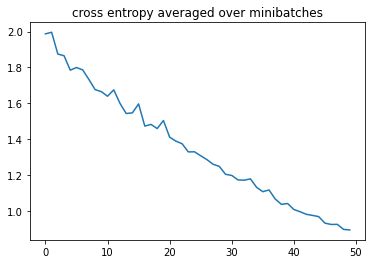

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]]) tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
Accuracy of predictions on the test set: 71.4286%


In [61]:
class GIN_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, aggregator, n_classes):
        super(GIN_Classifier, self).__init__()
        lin_1 = torch.nn.Linear(in_dim, hidden_dim)
        lin_2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv1 = dglnn.GINConv(lin_1, aggregator)
        self.conv2 = dglnn.GINConv(lin_2, aggregator)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
#         h = torch.reshape(h, (h.shape[0], -1))
        h = F.relu(self.conv2(g, h))
#         h = torch.reshape(h, (h.shape[0], -1))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


data_loader = GraphDataLoader(trainset, batch_size=16, shuffle=True)

model = GIN_Classifier(1, 16, 'sum', 2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
# test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
pred_Y = torch.argmax(probs_Y, dim=1, keepdim=True)
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(test_Y, pred_Y)
print('Accuracy of predictions on the test set: {:.4f}%'.format(
    (test_Y == pred_Y.float()).sum().item() / len(test_Y) * 100))
# print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
#     (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))